In [1]:
# Data paths and parameters
# Note: np.load will load saved dictionaries as a numpy array containinga dictionary. Use 'arrayname'.item() to get the actual dictionary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Paramters
binsize = 6
d1_name = 'Peripheral'             # name of dataset 1
d2_name = 'Perinuclear'              # name of dataset 2

savedir = "F:\Rtn4_Paper_Data\SP8\Inner_vs_Outer_Rtn4-intensity_analysis\Results"
d1dir = "F:\\Rtn4_Paper_Data\\SP8\\Inner_vs_Outer_Rtn4-intensity_analysis\\All_Outer_Lineplots"
d2dir = "F:\\Rtn4_Paper_Data\\SP8\\Inner_vs_Outer_Rtn4-intensity_analysis\\All_Inner_Lineplots"

# create list of files in data folder
d1_list = []
for path1 in os.listdir(d1dir):
    # check if current path is a file
    if os.path.isfile(os.path.join(d1dir, path1)):
        d1_list.append(path1)
        
d2_list = []
for path2 in os.listdir(d2dir):
    # check if current path is a file
    if os.path.isfile(os.path.join(d2dir, path2)):
        d2_list.append(path2)

In [2]:
import csv

# Calculate the average of each line plot for each dataset. Multiply the average by 10 (to get the 
# sum of intensities across the tubule averaged along the tubule)
d1_avg = []
for a in range(len(d1_list)):
    read_csv1 = pd.read_csv(d1dir + '\\' + d1_list[a])
    read_csv1 = np.array(read_csv1)
    for b in range(int(np.size(read_csv1, axis=1)/2)):
        col = read_csv1[:,(b*2)+1][~np.isnan(read_csv1[:,(b*2)+1])]
        avg = np.nanmean(col)
        d1_avg.append(avg)
d1_avg = np.array(d1_avg)
d1_avg = d1_avg * 10

d2_avg = []
for c in range(len(d2_list)):
    read_csv2 = pd.read_csv(d2dir + '\\' + d2_list[c])
    read_csv2 = np.array(read_csv2)
    for d in range(int(np.size(read_csv2, axis=1)/2)):
        col = read_csv2[:,(d*2)+1][~np.isnan(read_csv2[:,(d*2)+1])]
        avg = np.nanmean(col)
        d2_avg.append(avg)
d2_avg = np.array(d2_avg)
d2_avg = d2_avg * 10

In [3]:
# Function to remove outliers from data
def filter_outliers(data):
    '''
    -----
    Input
    -----
        data: (N,) numpy array of floats
            array to filter out outliers
            
    ------
    Output
    ------
        filt_data: (N-# of outliers,) numpy array of floats
            'data' with outliers removed
    '''
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    low_inds = data > lower_bound
    high_inds = data < upper_bound
    inds = low_inds * high_inds
    filt_data = data[inds]
    #outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
 
    return filt_data, inds

In [4]:
# use outlier filter function on averaged data
d1_filt, d1_inds = filter_outliers(d1_avg)
d2_filt, d2_inds = filter_outliers(d2_avg)

# Find the minimum and maximum of all data
absmin = np.min([np.min(d1_filt),np.min(d2_filt)])#,np.min(bg_avg)])
absmax = np.max([np.max(d1_filt),np.max(d2_filt)])#,np.max(bg_avg)])
roundmin = np.round(absmin,-1)
roundmax = np.round(absmax,-1)
if roundmin > absmin:
    roundmin = roundmin - 10

if roundmax < absmax:
    roundmax = roundmax + 10

# establish bins for histogram
bins = np.arange(roundmin,roundmax,binsize)

In [5]:
# Wilcoxon rank sum statistical test and save to pickled .npy file
from scipy.stats import ranksums
stats = ranksums(d1_filt,d2_filt)
save_stats = savedir + '\\' + d1_name +'_vs_' + d2_name + '.npy'
np.save(save_stats, stats, allow_pickle=True)

In [6]:
stats

RanksumsResult(statistic=1.981959836628253, pvalue=0.047483735991064424)

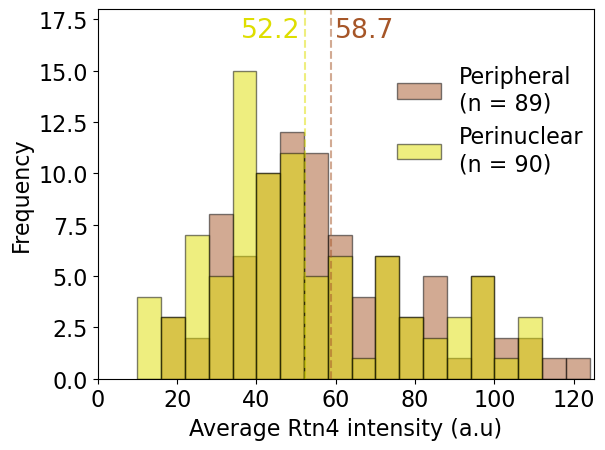

In [12]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

d1_mean = np.average(d1_filt)
d2_mean = np.average(d2_filt)

plt.rcParams.update({'font.size': 16}) #18
plt.rcParams.update({'legend.frameon': False})
fig = plt.figure()#figsize=[14,10])

plt.close(fig=None)
n1, bins1, patches1 = plt.hist(x=d1_filt,bins=bins, alpha=0.5, rwidth=1, density=False, color=CB_color_cycle[4],range=(0,roundmax),
                              label=d1_name + '\n(n = ' + str(len(d1_filt)) + ')',edgecolor='k')
n2, bins2, patches2 = plt.hist(x=d2_filt,bins=bins, alpha=0.5, rwidth=1, density=False, color=CB_color_cycle[8],range=(0,roundmax),
                              label=d2_name + '\n(n = ' + str(len(d2_filt)) + ')',edgecolor='k')
plt.xlim(0,125)
plt.ylim(bottom=0,top=18)#np.max([n1,n2])+(np.max([n1,n2])/10))
# Add dashed line at average value for d1
plt.axvline(x=d1_mean, linestyle='--',color=CB_color_cycle[4],alpha=0.5)
# Add average value as text on plot near top of average line for d1
plt.text(d1_mean+1,np.max([n1,n2])+(np.max([n1,n2])/7)-0.5,str(np.round(d1_mean,1)),color=CB_color_cycle[4], fontsize='large')
# Add dashed line at average value for d2
plt.axvline(x=d2_mean, linestyle='--',color=CB_color_cycle[8],alpha=0.5)
# Add average value as text on plot near top of average line for d2
plt.text(d2_mean-16,np.max([n1,n2])+(np.max([n1,n2])/7)-0.5,str(np.round(d2_mean,1)),color=CB_color_cycle[8], fontsize='large')
# Add p-value text onto plot
#plt.text(roundmax-20,np.max([n1,n2])-6,'p = ' + str(np.format_float_scientific(stats[1], precision=2)), fontsize='large')
plt.xlabel('Average Rtn4 intensity (a.u)')
plt.ylabel('Frequency')
plt.legend(loc='right',framealpha=0.25, bbox_to_anchor=(1.02,0.7))
fig.tight_layout()
hist_save = savedir + '\\' + d1_name +'_vs_' + d2_name + '.png'
plt.savefig(hist_save, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)
plt.show()

In [ ]:
stats